# A Supervised Transformer with PyTorch

Transformers, [first developed in 2017](https://arxiv.org/abs/1706.03762), are the model architecture on which all modern language models, such as ChatGPT, are based (of course, there have been significant architectural innovations since the original Transformer, but it still forms the foundation). Transformers rely almost entirely on the Attention mechanism to form an expressive representation of their input, from which many forms of desired output can be extracted. Today, we are going to use a modified Transformer model to predict the momentum of top quarks from their decay products, using data from Monte Carlo simulations of collision events in the CMS detector.

The top quark is unique in particle physics, as it is the only quark that decays via the weak nuclear force before hadronizing to form jets. It decays into a $W$ boson and a $b$ quark. The $b$ quark forms a particle jet, while the $W$ boson can decay to light quarks, or to a lepton and (anti)neutrino. All of our simulated events go through the latter sequence.

Our model architecture (implemented in `utils/Transformers.py`) is a modified version of the original Transformer. It contains two significant changes with respect to the initial design, both directly motivated by the difference between natural language and particle physics data:
- We do _not_ include any kind of positional encoding in the input to the Attention layers. In language modeling, this is inserted to introduce a dependence on the ordering of words in a sentence or paragraph, but particles have no implicit ordering, and we want the order in which we list them to have no meaning to the model. Thus, we remove this element.
- When passing "output" tokens to the model, the original input is usually included, but progressively "shifted right", to force the Attention mechanism to only be aware of "previous" tokens in the output. We also remove this mechanism, allowing Attention to operate between the two output tokens. This is because we want the model's predictions for the top quark and antiquark to both depend on each other.


Let's get started by importing the various elements we'll need, including our custom `RecoTransformer` class.

In [1]:
import os
# import pickle
from itertools import cycle
import numpy as np
import vector
import torch
from matplotlib import pyplot as plt

In [2]:
from utils.Transformers import RecoTransformer

Next, we'll create some global variables for common settings we'll need throughout the process. You should recognize most of these as general machine-learning things.

In [3]:
save_folder = "/depot/cms/users/colberte/ml-learning/PyTorch/SavedModels"
os.makedirs(save_folder, exist_ok=True)

batch_size = 2048
valid_batch_size = 16384
epochs = 2
learning_rate = 1.0e-4
grad_clip_value = 80.0

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
model_params = {
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    "d_model": 128,
    "n_heads": 8,
    "dim_feedforward": 354,
    "dropout": 0.09,
    "dim_embeddings": 378,
    "num_layers_embeddings": 1,
    "dim_outputs": 4,
}

### Setting Up Datasets

Now, it's time to load the training and validation data, and set it up to be batched dynamically during training. Notice that I use some extra options (`num_workers=1` and `pin_memory=True`) if we're training on a GPU -- these help speed up the transfer of data from main memory onto the GPU device.

Also, we're going to cycle through the validation data in batches as we train. It'd be lots of boring work and extra code to have to keep track of where we're at in the dataset and manually start over when we reach the end. Luckily, a `cycle` from Python's built-in `itertools` library can handle those mechanics for us.

In [6]:
train_dataset = torch.load("data/ttbar_dilepton_2017UL_notau_train.pt", weights_only=False)
valid_dataset = torch.load("data/ttbar_dilepton_2017UL_notau_validation.pt", weights_only=False)

In [7]:
if torch.cuda.is_available():
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)
else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, drop_last=True)

In [8]:
valid_dataloader_iterator = cycle(valid_dataloader)

For quick demonstration purposes, I'm shortening the training dataset so the model will train in a few minutes on a GPU slice. If you actually want a good model, you should fully comment out (or delete) this cell.

I repeat, for a decent model, **DON'T RUN THIS!!**

In [9]:
train_dataset_real = torch.utils.data.TensorDataset(*(train_dataset[:1000000]))
train_dataloader = torch.utils.data.DataLoader(train_dataset_real, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)

### Instantiating the Model

Here we create an instance of the `RecoTransformer` model. We can also inspect how many trainable parameters it has. With the settings we used in `model_params` above, we end up with just shy of 1.7 million trainable parameters. That's quite a few, but actually rather small for a Transformer! Luckily, our training data contains over 6 million collision events, so it should be possible to avoid large overfitting effects.

In [10]:
model = RecoTransformer(**model_params)
model = model.to(device)

In [11]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 1678266


### Setting up Training

Here we set up an optimizer (I'm partial to the _Adam_ optimization algorithm) and a loss function. I just use a basic Mean Absolute Error loss (implemented in PyTorch as `L1Loss`), but this is actually a great spot to play around! You might be surprised at how sensitive your trained model is to the specific choice of loss function.

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

In [13]:
loss_function = torch.nn.L1Loss(reduction="mean")

### Train!

Here's where the magic happens -- the training loop! Notice that at the end of every epoch, we take a moment to evaluate the performance of the model on data with which it _wasn't_ trained. This is an important principle in ML: ensure that your models generalize to data they haven't seen before. This "validation" step can also be used to implement _early stopping_, where you'll end your model's training once you start to see it overfit (a variation on this technique is commented out in the code below).

In [14]:
train_loss = []
valid_loss = []
# min_valid_loss = float("inf")
# min_loss_epoch = 0

In [15]:
for epoch in range(1, epochs+1):
    print(f"Starting epoch {epoch}.")
    model.train()
    for batch, (jets, leptons, met, pad_mask, target) in enumerate(train_dataloader):
        optimizer.zero_grad()

        jets = jets.to(device)
        leptons = leptons.to(device)
        met = met.to(device)
        pad_mask = pad_mask.to(device)
        #target = target.to(device)
        target = target.reshape([-1, 2, 4]).to(device)

        # Decoder requires initial "target" to attend to
        output_template_1 = 1 + torch.zeros([len(target), 1, model_params['d_model']], device=device)
        output_template_2 = -1 + torch.zeros([len(target), 1, model_params['d_model']], device=device)
        # output_template_1 = torch.zeros([len(target), 1, model_params['d_model']], device=device)
        # output_template_2 = 1 + torch.zeros([len(target), 1, model_params['d_model']], device=device)
        output_template = torch.cat([output_template_1, output_template_2], dim=1)

        pred = model(output_template, jets, leptons, met, pad_mask)

        loss = loss_function(pred, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value) # gradient clipping
        optimizer.step()

        if (batch % 10 == 0):
            train_loss_number = loss.detach().to("cpu").item()
            train_loss.append(train_loss_number)

    model.eval()
    with torch.no_grad():
        jets_valid, leptons_valid, met_valid, pad_mask_valid, target_valid = next(valid_dataloader_iterator)
        jets_valid = jets_valid.to(device)
        leptons_valid = leptons_valid.to(device)
        met_valid = met_valid.to(device)
        pad_mask_valid = pad_mask_valid.to(device)
        #target_valid = target_valid.to(device)
        target_valid = target_valid.reshape([-1, 2, 4]).to(device)

        output_template_valid_1 = 1 + torch.zeros([len(target_valid), 1, model_params['d_model']], device=device)
        output_template_valid_2 = -1 + torch.zeros([len(target_valid), 1, model_params['d_model']], device=device)
        # output_template_valid_1 = torch.zeros([len(target_valid), 1, model_params['d_model']], device=device)
        # output_template_valid_2 = 1 + torch.zeros([len(target_valid), 1, model_params['d_model']], device=device)
        output_template_valid = torch.cat([output_template_valid_1, output_template_valid_2], dim=1)

        pred_valid = model(output_template_valid, jets_valid, leptons_valid, met_valid, pad_mask_valid)

        loss_valid = loss_function(pred_valid, target_valid)

        valid_loss_number = loss_valid.detach().to('cpu').item()
        valid_loss.append(valid_loss_number)

        # if (valid_loss_number <= min_valid_loss):
        #     min_valid_loss = valid_loss_number
        #     min_loss_epoch = epoch
        #     # Save model with lowest validation loss
        #     torch.jit.script(model).save(save_folder+"/best_transformer.pt")

print("Finished.")

Starting epoch 1.
Starting epoch 2.


In [16]:
torch.jit.script(model).save(save_folder+"/final_transformer.pt")

### Evaluating the Results

Let's see how our model did! The first thing we can do is see how training went. Notice that I logged the loss value, on both training and validation data, during the training loop. We can plot this to see that the loss value (hopefully) decreased as the model's training progressed. 

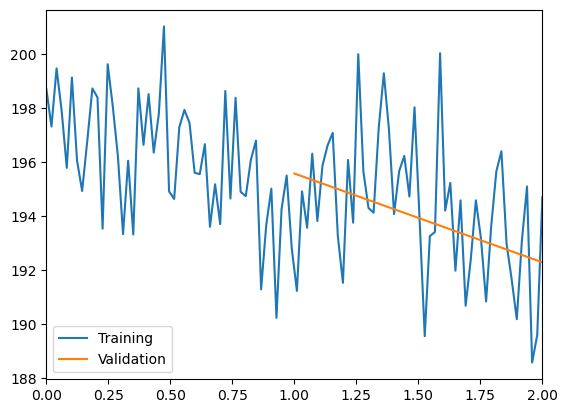

In [17]:
epochs_list = np.arange(1, epochs+1)
steps_list = np.linspace(0, epochs, len(train_loss))

fig, ax = plt.subplots()

ax.set_xlim(0, epochs)
#ax.set_ylim(bottom=0)

ax.plot(steps_list, train_loss, label="Training")
ax.plot(epochs_list, valid_loss, label="Validation")

ax.legend()

plt.show()
plt.close()

We see that the loss did indeed decrease -- our model trained! Now we can actually evaluate how well it does.

Plotting residuals (the 2D histograms) will go here.

### Wrapping Up

I hope this was a useful tutorial for everyone! I'll leave you with a few further explorations to try, which aren't implemented here:
1. _Standardize_ the model's inputs and/or outputs. Right now, there are features that have quite different orders of magnitude, and their distributions differ quite a bit. It often helps ML models if you transform their inputs and outputs to quantities that follow a standard normal distribution (check out Scikit-Learn's [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) for this).
2. How do we know the best size for all the model's parts to be, or the best batch size, learning rate, etc? I might have made some poor choices for those values when I set this up. To potentially improve the model's performance, do a _hyperparameter scan_, that is, train a variety of models with different values for those settings, and see if you can find where the best ones are. A number of tools exist to help with this; my favorite is [Optuna](https://optuna.org/). 